### Train a Simple Classifier

In our first session we learned about training a classifier on the MNIST Images. The thing about MNIST though is the dataset is very simple! Today we will repeat this, but with a slightly more complex dataset known as CIFAR10. This will also motivate why we love Convolutions later!



In [28]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


### Lets Explore the Data

We will load the data here, lets take a quick look at what it looks like!

Files already downloaded and verified


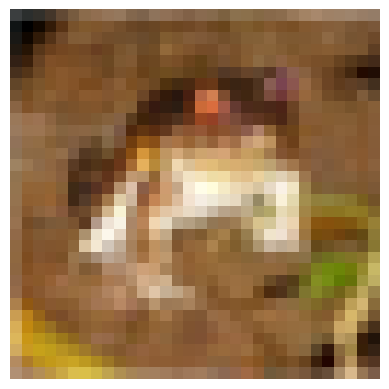

In [23]:

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)

sample, label = next(iter(trainset))

plt.imshow(np.array(sample))
plt.axis("off")
plt.show()

Thats a Frog! Just like MNIST there are 10 classes of images that we need to classify between!

### Define a Model

You can use any model shape you want, just use Linear layers only though. This means you can test how many hidden nodes to have in intermediate layers, and also how many layers you want in total. You can also play with different activation functions to see what works better!

In [26]:
class LinearNN(nn.Module):
    def __init__(self, input_size=32*32*3, num_classes=10):
        super(LinearNN, self).__init__()
        ### FILL IN MODEL PARTS ### 
        #first hidden layer
        self.fc1 = nn.Linear(input_size, 512)
        #second hidden layer
        self.fc2 = nn.Linear(512, 256)
        #third layer 
        self.fc3 = nn.Linear(256, 128)
        #fourth layer
        self.fc4 = nn.Linear(128, num_classes)
        
        #dropout layer
        #self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        ### FILL IN FORWARD FUNCTION ###
        #Flatten the input image
        x = x.view(-1, 32*32*3)
        #First
        #x = self.dropout(F.relu(self.fc1(x)))
        x = F.relu(self.fc1(x))
        #Second
        #x = self.dropout(F.relu(self.fc2(x)))
        x = F.relu(self.fc2(x))
        #Third
        #x = self.dropout(F.relu(self.fc3(x)))
        x = F.relu(self.fc3(x))
        #Fourth
        x = self.fc4(x)
        return x


### Define a Dataloader

We Now need to prepare our dataloader with the batch size we want to train with! I provide the datasets here (with some simple image transforms such as converting PIL to tensor and then normalizing). Create the dataloaders from that!

In [27]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

BATCH_SIZE = 128
LOSS = nn.CrossEntropyLoss()
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True, num_workers = 1)
testloader = DataLoader(testset, batch_size = BATCH_SIZE, shuffle = False, num_workers = 1)


Files already downloaded and verified
Files already downloaded and verified


### Train a Model

Train your model for however many epochs you want. Make sure to calculate the average loss and accuracy per epoch for both the training set and evaluation set so we can plot our training curves after!

Things we need to set:

- Device
- Loss Function (what loss do we use for classification?)
- Optimizer (you can use whatever you want, and whatever learning rate you want)

In [30]:
### Set the Device ###
device = "cuda" if torch.cuda.is_available() else "cpu"
### Set the Loss Function ###
criterion = nn.CrossEntropyLoss()

### Load the Model ###
model = LinearNN().to(device)

### Set the Optimizer ###
learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

### Training Loop ###
EPOCHS = 20

# Store metrics
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []


for epoch in range(1, EPOCHS + 1):
    print(f"EPOCH {epoch}")
    
    # Training
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for X, y in trainloader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        outputs = model(X)
        loss = criterion(outputs, y)  # No need for .float()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        predicted = torch.argmax(outputs, dim=1)
        correct += (predicted == y).sum().item()
        total += y.size(0)

    train_loss_epoch = running_loss / len(trainloader)
    train_acc_epoch = round(correct / total, 2)
    train_losses.append(train_loss_epoch)
    train_accuracies.append(train_acc_epoch)
    print(f"Train Loss: {train_loss_epoch:.4f} | Accuracy: {train_acc_epoch}")

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for X, y in testloader:
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            loss = criterion(outputs, y)
            val_loss += loss.item()

            predicted = torch.argmax(outputs, dim=1)
            correct += (predicted == y).sum().item()
            total += y.size(0)

    val_loss_epoch = val_loss / len(testloader)
    val_acc_epoch = round(correct / total, 2)
    val_losses.append(val_loss_epoch)
    val_accuracies.append(val_acc_epoch)
    print(f"Val Loss: {val_loss_epoch:.4f} | Accuracy: {val_acc_epoch}")

print("Done")

#With this model 10 Epochs introduce an overfitting around 6-7 epochs flattening out at 51% for val and %59 for training.
    #^^ Epochs: 10 batch size = 128 learning rate: .005 Started drop out at 512 to 256 to 128 to 10
#CHANGE the way Drop out works introduce self.dropout() with self.dropout = nn.Dropout(0.3) see change (research led to this)
    #produced the best at epoch 7-8 with training accuracy 31% and val accuracy 37% 
    #try dropout with self.dropout = nn.Dropout(0.5)
#CHANGE self.dropout = nn.Dropout(0.5)
    #produced even worse results with best at epoch 3 training accuracy 20% and val accuracy 25%
#CHANGE back to original model w/ epoch = 20
    #model introduces a best at epoch 20 with train accuracy 68% and val accuracy 52%
    #Best results so far
#CHANGE learning rate to .001 to see what happens
    #best results
    #At epoch 12 with training accuracy at 78% val accuracy at 55%
    #Training accuracy increases all the way to 89% and val accuracy at 53% at epoch 19-20


EPOCH 1
Train Loss: 1.6589 | Accuracy: 0.41
Val Loss: 1.5033 | Accuracy: 0.48
EPOCH 2
Train Loss: 1.4363 | Accuracy: 0.49
Val Loss: 1.4369 | Accuracy: 0.49
EPOCH 3
Train Loss: 1.3172 | Accuracy: 0.53
Val Loss: 1.3759 | Accuracy: 0.51
EPOCH 4
Train Loss: 1.2176 | Accuracy: 0.57
Val Loss: 1.3482 | Accuracy: 0.53
EPOCH 5
Train Loss: 1.1329 | Accuracy: 0.6
Val Loss: 1.3405 | Accuracy: 0.54
EPOCH 6
Train Loss: 1.0502 | Accuracy: 0.63
Val Loss: 1.3569 | Accuracy: 0.53
EPOCH 7
Train Loss: 0.9705 | Accuracy: 0.65
Val Loss: 1.3869 | Accuracy: 0.54
EPOCH 8
Train Loss: 0.8971 | Accuracy: 0.68
Val Loss: 1.3762 | Accuracy: 0.54
EPOCH 9
Train Loss: 0.8217 | Accuracy: 0.71
Val Loss: 1.4430 | Accuracy: 0.54
EPOCH 10
Train Loss: 0.7523 | Accuracy: 0.73
Val Loss: 1.4915 | Accuracy: 0.54
EPOCH 11
Train Loss: 0.6837 | Accuracy: 0.75
Val Loss: 1.5420 | Accuracy: 0.54
EPOCH 12
Train Loss: 0.6160 | Accuracy: 0.78
Val Loss: 1.7033 | Accuracy: 0.55
EPOCH 13
Train Loss: 0.5618 | Accuracy: 0.8
Val Loss: 1.7829 |

### Plot Loss and Accuracy

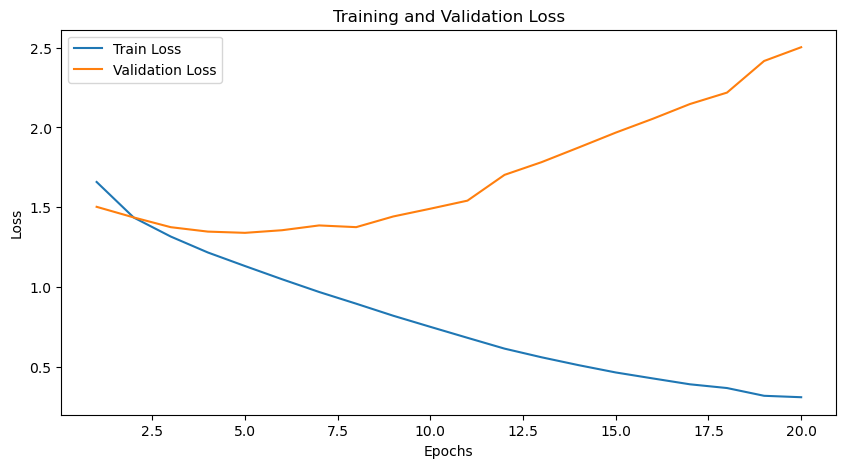

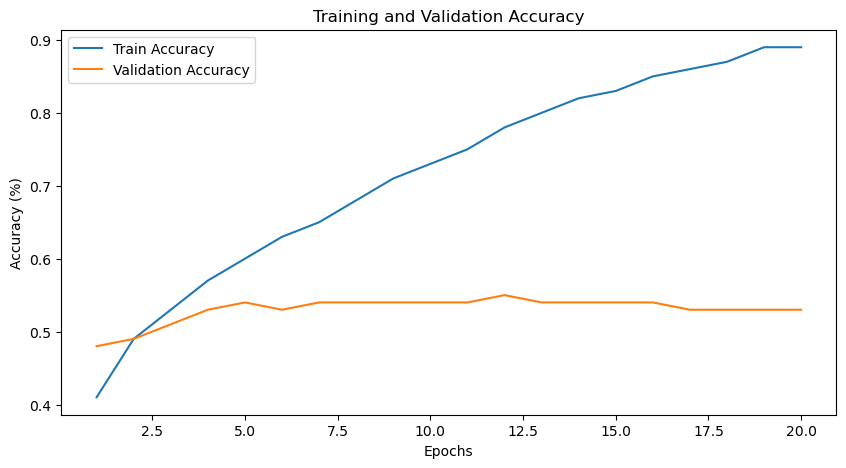

In [32]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, EPOCHS + 1), train_losses, label='Train Loss')
plt.plot(range(1, EPOCHS + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, EPOCHS + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, EPOCHS + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()